## Определение перспективного тарифа для телеком компании
### Постановка задачи
Необходимо проанализировать тарифы федерального оператора сотовой связи "Мегалайн". Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Необходимо произвести  предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание данных
В нашем распоряжении находятся пять таблиц.
##### Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

##### Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

##### Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

##### Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

##### Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### 1. Открыть файл с данными и изучить общую информацию

In [4]:
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import pylab as pl
data_calls = pd.read_csv('calls.csv')
data_internet = pd.read_csv('internet.csv')
data_messages = pd.read_csv('messages.csv')
data_tariffs = pd.read_csv('tariffs.csv')
data_users = pd.read_csv('users.csv')

In [5]:
print('---Информация о звонках---')
display(data_calls.head(10))
data_calls.info()
data_calls.query('duration == 0').count()

---Информация о звонках---


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


id           39613
call_date    39613
duration     39613
user_id      39613
dtype: int64

##### Вывод
- Датасет с информацией о звонках состоит из 202607 строк и 5 колонок.
- В колонках содержится иформация: уникальный id звонка, дата звонка, продолжительность звонка и id пользователя.
- Пропуски отсутствут.
- Тип данных в колонке с датой определен как object, что является неверным типом (необходимо привести к datetime).
- В колонке о продолжительности звонков ('duration') наблюдаем большое количесво звонков (39613) с продолжительностью, равной 0. Потребуется проверка.

In [6]:
print()
print('---Информация об интернет-сессиях---')
display(data_internet.head(10))
data_internet.info()
data_internet['Unnamed: 0']


---Информация об интернет-сессиях---


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


0              0
1              1
2              2
3              3
4              4
           ...  
149391    149391
149392    149392
149393    149393
149394    149394
149395    149395
Name: Unnamed: 0, Length: 149396, dtype: int64

##### Вывод
- Датасет с информацией об Интернет-сессиях состоит из 149396 строк и 5 колонок.
- Присутствует колонка 'Unnamed: 0', которая не содержит какой-либо качественной информации, помимо дублирования индекса. Похоже на ошибку в выгрузке данных. Данную колонку удалим.
- Пропуски отсутствуют.
- Колонка с датой неверно отражена по типу данных (как object).


In [7]:
print('---Информация о сообщениях---')
display(data_messages.head(10))
data_messages.info()

---Информация о сообщениях---


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


##### Вывод
- Датафрейм с информацией о сообщениях состоит из 123036 строк и 3 колонок.
- Пропуски отсутствуют.
- Колонка с датой неверно отражена в качестве типа object.


In [8]:
print('---Информация о пользователях---')
display(data_users.head(10))
data_users.info()

---Информация о пользователях---


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


##### Вывод
- Датафрейм с информацией о пользователях состоит из 500 строк и 8 колонок.
- В колонке 'churn_date' - дата прекращения пользования тарифом - пропущено 462 значения. Однако это означает, что тариф еще действовал на момент выгрузки данных, и, следовательно, данные пропуски не требуют замены. Также у данной переменной неверно отражен тип данных в качестве object.  
- Колонка с датой подключения тарифа ('reg_date') неверно отражена по типу данных как object.

In [9]:
print('---Информация о тарифах---')
display(data_tariffs)
data_tariffs.info()


---Информация о тарифах---


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


##### Вывод
- Датафрейм с информацией о тарифах содержит 2 строки и 8 колонок.


#### Общий вывод по результатам первичного обзора данных:
- В нашем распоряжении пять датафреймов, четыре из которых в том или ином виде содержат информацию о пользователях и их активности в пользовании услугами связи (информация о произведенных и отправленных каждым пользователем звонках, сообщениях и интернет сессиях, а также список самих пользователей, нформация о чьих звонках, сообщениях и интернет-сессиях отражена в соответствующих других датафреймах). Последний пятый датафрейм содержит информацию о парамаетрах двух имеющихся тарифов "Смарт" и "Ультра".
- Общим столбцом всех датафреймов о пользователях является 'user_id' c идентификационным номером пользователя. Данная переманная выражена в целочисленном типе int, однако по своему характеру является категориальной так как отражает уникального пользователя.
- Данные во всех датафреймах в целом выгружены корректно, пропуски содежатся только в колонке 'churn_date', однако это показатель того, что клиент все еще пользуется тарифом.
- Остальные переменные, которые будут необходимы для проведения расчетов, являются числовыми - данные о количестве мегабайт, продолжительности звонков и количестве сообщени.
- Местами содержатся ошибки в виде некорректного отражения типа переменных с данными о времени.
- Присутствует колонка 'Unnamed: 0', которая не содержит какой-либо качественной информации, помимо дублирования индекса. Похоже на ошибку в выгрузке данных. Данную колонку удалим.
- В датафрейме о звонках в колонке о продолжительности звонков ('duration') наблюдаем большое количесво звонков (39613) с продолжительностью, равной 0. Потребуется проверка.


<font color='green'>Данные загружены и изучены. Используются верные методы для получения общей информации о таблице. Найдены немногочисленные проблемы. Действительно, данные типа id можно привести к типу object: мы не собираемся применять к ним какие-либо арифметические операции, а в случае, если это все же произойдет, мы бы хотели увидеть ошибку.

### 2. Предобработка данных

In [10]:
#заменим типы данных с датами на тип datetime
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'])
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'])
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'])
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'])
data_users['churn_date'] = pd.to_datetime(data_users['churn_date'])

In [11]:
#проверим данные на дубликаты
data_calls.duplicated().sum()
data_internet.duplicated().sum()
data_messages.duplicated().sum()
data_users.duplicated().sum()


0

##### Вывод
- Дубликаты отсутствуют.

In [12]:
#удалим столбец с дубликатами индексов в датафрейме об интернет-сессиях
data_internet.drop(columns='Unnamed: 0', axis=1, inplace=True)
data_internet

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


(user_id
 1377    336
 1168    308
 1453    295
 1375    290
 1196    262
        ... 
 1206      6
 1442      5
 1406      5
 1084      5
 1424      5
 Name: id, Length: 492, dtype: int64,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000235C5C13608>]],
       dtype=object))

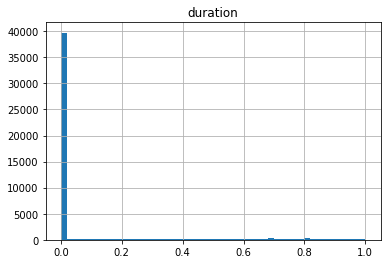

In [13]:
#исследует аномальные "нулевые" звонки датафрейме о звонках
null_calls = data_calls.loc[data_calls['duration'] == 0]
#сгруппируем строки с "нулевыми звонками" по пользователям, а также построим гистограмму продолжительности звонков меньще 1 мин
null_calls.groupby('user_id')['id'].count().sort_values(ascending=False), data_calls.query('duration < 1').hist(column='duration', bins=50, range=(0, 1))

##### Вывод
- Как видно из группировки данных по пользователям, практически у всех пользователей (в 492 из 500) присутствуют "нулевые" звонки. 
- Данные наблюдения не позволяют сделать обоснованных утверждений о наличии каких-либо закономерностей или зависимостей в распределении "нулевых" звонков.  Можно предположить, что это эти значения отобразились в результате либо (1) сброса или недозвона, либо (2) ошибки в выгрузке данных.
- Оставим эти значения и не будем их засчитывать для подсчета стоимости звонков.

<font color='green'>Согласен, в данных есть очень короткие разговоры, то есть нули это что-то другое. Очень вероятно, что сброшенные/неотвеченные звонки.

In [14]:
#округлим значения количества мин. звонков и интернет-трафика
data_calls['duration'] = np.ceil(data_calls.duration).astype('int')
data_internet['mb_used'] = np.ceil(data_internet.mb_used).astype('int')
display('---Инфомация о звонках---', data_calls.head(10))
display('---Информация об интернет-сессиях', data_internet.head())

'---Инфомация о звонках---'

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000
5,1000_5,2018-11-02,0,1000
6,1000_6,2018-10-18,0,1000
7,1000_7,2018-08-22,19,1000
8,1000_8,2018-09-15,19,1000
9,1000_9,2018-08-15,0,1000


'---Информация об интернет-сессиях'

,id,mb_used,session_date,user_id
0,1000_0,113,2018-11-25,1000
1,1000_1,1053,2018-09-07,1000
2,1000_2,1198,2018-06-25,1000
3,1000_3,551,2018-08-22,1000
4,1000_4,303,2018-09-24,1000


<font color='green'>Молодец, что не забыл не только округлить, но и поменять тип.

### 3. Исследовательский анализ данных
#### 3.1. Посчитать для каждого пользователя:

1) количество сделанных звонков и израсходованных минут разговора по месяцам;

2) количество отправленных сообщений по месяцам;

3) объем израсходованного интернет-трафика по месяцам;

4) помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).


#### Добавим столбец с номером месяца в каждый из трех датафреймов (звонки, сообщения, интернет)

In [15]:
#добавим в таблицу звонков столбец с номером месяца для каждого звонка
data_calls['month'] = data_calls['call_date'].dt.month
#добавим в таблицу звонков столбец с номером месяца для каждого сообщения
data_messages['month'] = data_messages['message_date'].dt.month
#добавим столбец c номером месяца для каждой интернет-сессии
data_internet['month'] = data_internet['session_date'].dt.month

#### Сгруппируем даныее по месяцам для каждого пользователя (количество звонков, мегабай, сообщений, минут)

In [16]:
#выведем количество звонков по месяцам
month_calls_count = data_calls.groupby('user_id').agg({'month': ['value_counts']})
month_calls_count = month_calls_count.reset_index()
month_calls_count.columns = ['user_id', 'month', 'calls']
#сгруппируем количество израсходованных минут по месяцам на каждого пользователя
minutes_calls_sum = data_calls.groupby(['user_id', 'month']).agg({'duration': ['sum']})
minutes_calls_sum = minutes_calls_sum.reset_index()
minutes_calls_sum.columns = ['user_id', 'month', 'minutes']
#сгруппируем количество отправленных сообщений по месяцам на каждого пользователя
month_messages_count = data_messages.groupby('user_id').agg({'month': ['value_counts']})
month_messages_count = month_messages_count.reset_index()
month_messages_count.columns = ['user_id', 'month', 'messages']
#найдем объем израсходанного интернет-траффика по месяцам
month_internet_sum = data_internet.groupby(['user_id', 'month']).agg({'mb_used': ['sum']})
month_internet_sum = month_internet_sum.reset_index()
month_internet_sum.columns = ['user_id', 'month', 'mb_agg']

<font color='green'>В таблицу успешно добавлена информация о месяцах. Данные аггрегированы
    .

#### Подсчитаем помесячную выручку на каждого пользователя

Для этого сформируем итоговую таблицу для последующих расчетов выручки и проверки гипотез

In [17]:
#создадим в два этапа единую таблицу с данными о расходовании звонков, интернет-траффика и сообщений 
#посредством соединения соответствующих таблиц по колонкам 'month' и 'user_is'
#новую промежуточную таблицу назовем "data_agg"
merge_1 = pd.merge(pd.merge(month_calls_count,minutes_calls_sum, on=['user_id', 'month'], how='outer'),month_messages_count, on=['user_id', 'month'], how='outer')
general_count = pd.merge(merge_1, month_internet_sum, on=['user_id', 'month'], how='outer')
data_agg = pd.merge(general_count, data_users[['user_id','tariff']], on='user_id', how='left')
data_cities = data_users[['user_id', 'city']]
data_agg = pd.merge(data_agg, data_cities, on='user_id', how='outer')
data_agg = data_agg.fillna(0)
data_agg['mb_agg'] = data_agg['mb_agg']/1000
data_agg['mb_agg'] = data_agg.mb_agg.round()
data_agg

,user_id,month,calls,minutes,messages,mb_agg,tariff,city
0,1000,9.0,58.0,466.0,57.0,15.0,ultra,Краснодар
1,1000,10.0,57.0,350.0,73.0,15.0,ultra,Краснодар
2,1000,8.0,52.0,408.0,81.0,14.0,ultra,Краснодар
3,1000,7.0,47.0,340.0,75.0,14.0,ultra,Краснодар
4,1000,12.0,46.0,333.0,70.0,10.0,ultra,Краснодар
...,...,...,...,...,...,...,...,...
3211,1489,10.0,0.0,0.0,21.0,20.0,smart,Санкт-Петербург
3212,1489,11.0,0.0,0.0,20.0,18.0,smart,Санкт-Петербург
3213,1489,8.0,0.0,0.0,17.0,11.0,smart,Санкт-Петербург
3214,1128,0.0,0.0,0.0,0.0,0.0,0,Волжский


<font color='green'>Данные объеденены верно. Получилась очень удобная компактная таблица, содержащая все необходимые данные. Молодец, что используешь метод объединения outer, так мы не теряем строки.

#### Посчитаем выручку на кажого пользователя по месяцам в соответствии с тарифами

In [18]:
#создадим функцию для расчета выручки в соответствии с тарифами
#переменные тарифа "Ультра"
minutes_included_ultra = data_tariffs.loc[1, 'minutes_included']
messages_included_ultra = data_tariffs.loc[1, 'messages_included']
rub_per_gb_ultra = data_tariffs.loc[1, 'rub_per_gb']
mb_per_month_included_ultra = data_tariffs.loc[1, 'mb_per_month_included']
rub_monthly_fee_ultra = data_tariffs.loc[1, 'rub_monthly_fee']
rub_per_minute_ultra =  data_tariffs.loc[1, 'rub_per_minute']
rub_per_message_ultra = data_tariffs.loc[1, 'rub_per_message']
#переменные тарифа "Смарт"
minutes_included_smart = data_tariffs.loc[0, 'minutes_included']
messages_included_smart = data_tariffs.loc[0, 'messages_included']
rub_per_gb_smart = data_tariffs.loc[0, 'rub_per_gb']
mb_per_month_included_smart = data_tariffs.loc[0, 'mb_per_month_included']
rub_monthly_fee_smart = data_tariffs.loc[0, 'rub_monthly_fee']
rub_per_minute_smart =  data_tariffs.loc[0, 'rub_per_minute']
rub_per_message_smart = data_tariffs.loc[0, 'rub_per_message']

def income_calculation(users_data):
        minutes = users_data['minutes']
        messages = users_data['messages']
        mb_agg = users_data['mb_agg']
        for row in users_data: # здесь начинается расчет выручки по тарифу "Ультра"
            if users_data['tariff'] == 'ultra':
                if minutes <= minutes_included_ultra:
                    calls_income = 0
                else: #создадим три переменные для расчета выручки по виду услуг (звонки, сообщения, интернет)
                    calls_income = (minutes - minutes_included_ultra)*rub_per_minute_ultra
                if messages <= messages_included_ultra:
                    messages_income = 0
                else:
                    messages_income = (messages - messages_included_ultra)*rub_per_message_ultra
                if mb_agg <= mb_per_month_included_ultra:
                    internet_income = 0
                else:
                    internet_income = (mb_agg - mb_per_month_included_ultra)*rub_per_gb_ultra
                income = calls_income + messages_income + internet_income + rub_monthly_fee_ultra  #общая выручка равна сумме выручек по виоду услуг и абонентской платы
                return income
            # здесь расчет выручки по тарифу "Смарт"
            if users_data['tariff'] == 'smart': 
                if minutes <= minutes_included_smart:
                    calls_income = 0
                else:
                    calls_income = (minutes - minutes_included_smart)*rub_per_minute_smart
                if messages <= messages_included_smart:
                    messages_income = 0
                else:
                    messages_income = (messages - messages_included_smart)*rub_per_message_smart
                if mb_agg <= mb_per_month_included_smart:
                    internet_income = 0
                else:
                    internet_income = (mb_agg - mb_per_month_included_smart)*rub_per_gb_smart
                income = calls_income + messages_income + internet_income + rub_monthly_fee_smart
                return income

           

data_agg['income'] = data_agg.apply(income_calculation, axis=1)

data_agg = data_agg.fillna(0)


In [19]:
data_agg.columns = ['user_id', 'month', 'calls', 'minutes', 'messages', 'gb_agg', 'tariff', 'city', 'income']

In [20]:
data_agg

,user_id,month,calls,minutes,messages,gb_agg,tariff,city,income
0,1000,9.0,58.0,466.0,57.0,15.0,ultra,Краснодар,1950.0
1,1000,10.0,57.0,350.0,73.0,15.0,ultra,Краснодар,1950.0
2,1000,8.0,52.0,408.0,81.0,14.0,ultra,Краснодар,1950.0
3,1000,7.0,47.0,340.0,75.0,14.0,ultra,Краснодар,1950.0
4,1000,12.0,46.0,333.0,70.0,10.0,ultra,Краснодар,1950.0
...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,0.0,0.0,21.0,20.0,smart,Санкт-Петербург,550.0
3212,1489,11.0,0.0,0.0,20.0,18.0,smart,Санкт-Петербург,550.0
3213,1489,8.0,0.0,0.0,17.0,11.0,smart,Санкт-Петербург,550.0
3214,1128,0.0,0.0,0.0,0.0,0.0,0,Волжский,0.0



#### 3.2. Анализ активности пользователей тарифов  "Смарт" и "Ультра"
- Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?
- Посчитать среднее количество, дисперсию и стандартное отклонение. 
- Построить гистограммы. Опишите распределения.

### Звонки

Дисперсия затраченных минут пользователей тарифа "Смарт": 36219.315784344246
Дисперсия затраченных минут пользователей тарифа "Ультра": 100873.63339730087


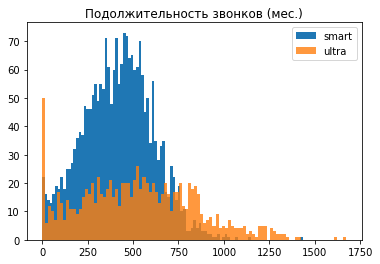

'Тариф "Смарт"'

count    2229.000000
mean      417.934948
std       190.313730
min         0.000000
25%       282.000000
50%       422.000000
75%       545.000000
max      1435.000000
Name: minutes, dtype: float64

'Тариф "Ультра"'

count     985.000000
mean      526.623350
std       317.606098
min         0.000000
25%       284.000000
50%       518.000000
75%       752.000000
max      1673.000000
Name: minutes, dtype: float64

In [21]:
#показатели по звонкам 
print('Дисперсия затраченных минут пользователей тарифа "Смарт":', data_agg.loc[data_agg['tariff'] == 'smart', 'minutes'].var())
print('Дисперсия затраченных минут пользователей тарифа "Ультра":', data_agg.loc[data_agg['tariff'] == 'ultra', 'minutes'].var())
%matplotlib inline
pl.title("Подолжительность звонков (мес.)")
minutes_smart = data_agg.loc[data_agg['tariff'] == 'smart', 'minutes']
minutes_ultra = data_agg.loc[data_agg['tariff'] == 'ultra', 'minutes']

plt.hist(minutes_smart, bins=100, label='smart')
plt.hist(minutes_ultra, bins=100, alpha=0.8, label='ultra')
plt.legend(loc='best')
plt.show()
display('Тариф "Смарт"', data_agg.loc[data_agg['tariff'] == 'smart', 'minutes'].describe())
display ('Тариф "Ультра"', data_agg.loc[data_agg['tariff'] == 'ultra', 'minutes'].describe())

##### Вывод по тарифу "Смарт"
- В среднем в месяц каждый пользователь тарифа "Смарт" тратит около 417 минут (в пределах включенного в пакет лимита).
- Гистограмма выглядит несемметрично в силу резкого снижения количества пользователей, чьи разговоры составляют более 600 мин. в месяц.
- Количество звонков с превышением пакетного лимита составляет около четверти в месяц. 
- Гистограмма упирается в ноль, поскольку ранее мы отмечали большое количество "нулевых" зконков.

##### Вывод по тарифу "Ультра"
- Средняя продолжительность звонка в месяц пользователей с тарифом "Ультра" составляет 526 мин (примерно половина пользователей также разговаривают не более этой продолжительности). 

### Сообщения

Дисперсия отправляемых сообщений пользователей тарифа "Смарт": 796.8129584480083
Дисперсия отправляемых сообщений пользователей тарифа "Ультра": 2285.2661425446818


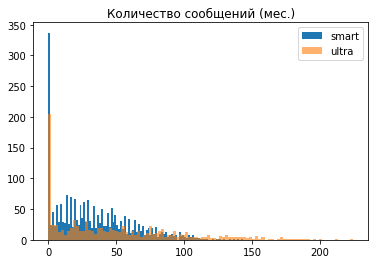

'Тариф "Смарт"'

count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages, dtype: float64

'Тариф "Ультра"'

count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: messages, dtype: float64

In [22]:
#показатели по сообщениям
messages_smart = data_agg.loc[data_agg['tariff'] == 'smart', 'messages']
messages_ultra = data_agg.loc[data_agg['tariff'] == 'ultra', 'messages']
print('Дисперсия отправляемых сообщений пользователей тарифа "Смарт":', messages_smart.var())
print('Дисперсия отправляемых сообщений пользователей тарифа "Ультра":', messages_ultra.var())
%matplotlib inline
pl.title("Количество сообщений (мес.)")

plt.hist(messages_smart, bins=100, label='smart')
plt.hist(messages_ultra, bins=100, alpha=0.6, label='ultra')
plt.legend(loc='best')
plt.show()
display('Тариф "Смарт"', messages_smart.describe())
display ('Тариф "Ультра"', messages_ultra.describe())


##### Вывод по тарифу "Смарт"
- Среднее количество сообщений пользователей тарифа "Смарт" составляет 33 сообщения в месяц (в пределах лимита, полностью включенные сообщения в пакет не расходуются).
- С превышением доступного лимита сообщения отправляют около четверти всех отправляемых сообщений.
- Примерно в 1/8 случаев пользователи не пользуется сообщениями в течение месяца вообще.

##### Вывод по тарифу "Смарт"
- Среднее количество сообщений пользователей с тарифом "Ультра" составляет 49 сообщений в месяц.

### Интернет

Дисперсия израсходованного траффика пользователей тарифа "Смарт": 34.64748101772532
Дисперсия израсходованного траффика пользователей тарифа "Ультра": 101.96338780900524


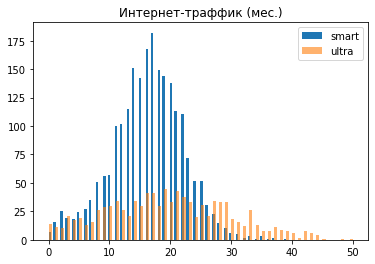

'Тариф "Смарт"'

count    2229.000000
mean       16.226559
std         5.886211
min         0.000000
25%        13.000000
50%        17.000000
75%        20.000000
max        39.000000
Name: gb_agg, dtype: float64

'Тариф "Ультра"'

count    985.000000
mean      19.483249
std       10.097692
min        0.000000
25%       12.000000
50%       19.000000
75%       27.000000
max       50.000000
Name: gb_agg, dtype: float64

In [23]:
#показатели по интернет-траффику
internet_smart = data_agg.loc[data_agg['tariff'] == 'smart', 'gb_agg']
internet_ultra = data_agg.loc[data_agg['tariff'] == 'ultra', 'gb_agg']
print('Дисперсия израсходованного траффика пользователей тарифа "Смарт":', internet_smart.var())
print('Дисперсия израсходованного траффика пользователей тарифа "Ультра":', internet_ultra.var())
%matplotlib inline

pl.title("Интернет-траффик (мес.)")

plt.hist(internet_smart, bins=100, label='smart')
plt.hist(internet_ultra, bins=100, alpha=0.6, label='ultra')
plt.legend(loc='best')
plt.show()
display('Тариф "Смарт"', internet_smart.describe())
display ('Тариф "Ультра"', internet_ultra.describe())



##### Вывод по тарифу "Смарт"
- Распределение расходуемых гигабайт в мес. тарифа "Смарт" близко к нормальному, то есть средний объем интернет-траффика в месяц, который составляет около 16 Гб и 200 Мб практически совпадает с медианным значением (16 Гб и 531 Мб).
- Половина пользователей укладывается в бесплатный пакет, а половина использует интернет сверх бесплатного лимита.

##### Вывод по тарифу "Ультра"
- Распределение по интернет-траффику близко к нормальному. Среднее количество израсходованного траффика в месяц составляет около 19.5 Гб (примерно столько же приходится и на медианное значение).
- Большая часть пользователей тарифа "Ультра" испольозуют интернет в пределах доступного лимита (около 30 Гб).

### 4. Проверка гипотез
#### 4.1. Гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

In [30]:
#выделим в отдельные массивы выборки с данными о выручке с пользователей соответствующих тарифив
income_ultra = data_agg.loc[data_agg['tariff'] == 'ultra', 'income']
income_smart = data_agg.loc[data_agg['tariff'] == 'smart', 'income']


#посчитаем среднюю выручку для пользователей 
print('Средняя выручка пользователей тарифа "Ультра" составляет:', round(income_ultra.mean()), 'рублей')
print('Cредняя выручка пользователей тарифа "Смарт" составляет:', round(income_smart.mean()), 'рублей')
#посмотрим на дисперсию этих выборок
print('Дисперсия выручки по тарифу "Ультра" составляет:', income_ultra.var())
print('Дисперсия выручки по тарифу "Смарт" составляет:', income_smart.var())

Средняя выручка пользователей тарифа "Ультра" составляет: 1950 рублей
Cредняя выручка пользователей тарифа "Смарт" составляет: 692 рублей
Дисперсия выручки по тарифу "Ультра" составляет: 0.0
Дисперсия выручки по тарифу "Смарт" составляет: 68131.24162440197


Проверим гипотезу о том, что средние выручки по тарифам различаются. Для этого сформулируем нулевую и альтернативную гипотезы:
- Нулевая гипотеза: "Средняя выручка с пользователей тарифа "Ультра" равна средней выручки пользователей тарифа "Смарт".
- Альтернативная гипотеза: "Средняя выручка с пользователей тарифа "Ультра" не равна средней выручки пользователей тарифа "Смарт" (разница между ними существенная)".

Вывод будет зависеть от выведенного значения p-value. Если оно окажется меньше заданного уровня статистической значимости (возьмем значимость в 0.05), то нулевая гипотеза должна быть отвергнута. Если же p-value будет больше выбранного уровня значимости, то вероятность нулевой гипотезы быть близкой к истине можно считать значительной и не отвергать ее.  


In [31]:
alpha = .05 

compare_tariffs = st.ttest_ind(
    income_ultra, 
    income_smart)

print('p-значение:', compare_tariffs.pvalue)

if (compare_tariffs.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0
Отвергаем нулевую гипотезу


##### Вывод
- Не можем принять нулевую гипотезу. Средние выручки с каждого пользователя тарифов "Смарт" и "Ультра" различаются.

#### 4.2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
- Нулевая гипотеза: "Средняя выручка с жителей Москвы равна средней выручке пользователей из других регионов".
- Альтернативная гипотеза: "Средняя выручка с жителей Москвы не равна средней выручке пользователей из других регионов".

In [32]:
#выделим в отдельные переменные выручку с жителей Москвы (data_income_moscow) и регионов (data_income_regions)
data_income_moscow = data_agg.loc[data_agg['city'] == 'Москва', 'income']
data_income_regions = data_agg.loc[data_agg['city'] != 'Москва', 'income']

print('Средняя выручка с жителей Москвы:', data_income_moscow.mean(), 'руб.')
print('Средняя выручка с жителей Москвы:', data_income_regions.mean(), 'руб.')
print('Дисперсия по  Москве:', data_income_moscow.var())
print('Дисперсия по регионам:', data_income_regions.var())

compare_regions = st.ttest_ind(
    data_income_moscow, 
    data_income_regions)

print('p-значение:', compare_regions.pvalue)

if (compare_regions.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средняя выручка с жителей Москвы: 1147.859247135843 руб.
Средняя выручка с жителей Москвы: 1060.4065259117083 руб.
Дисперсия по  Москве: 410704.0063856655
Дисперсия по регионам: 376543.9648575496
p-значение: 0.0016841459404615233
Отвергаем нулевую гипотезу


#### Вывод
- Нулевую гипотезу отвергаем. Средняя выручка с жителей Москвы сильно отличается от средней выручки с жителей других регионов. 

### Общий вывод

##### Выводы по активности пользователей тарифов "Смарт" и "Ультра"
- Средняя продолжительность звонков по обоим тарифам не превышает 500 мин. В целом пользователи разговаривают в пределах доступных лимитов соответствующих тарифов. С превышением лимитов разговаривает только четверть пользователей тарифа "Смарт".
- Среднее количество отправляемых сообщенией в месяц пользователей тарифа "Ультра" выше чем у пользователей тарифа "Смарт" (49 против 33).
- Пользователи тарифа "Ультра" более активно проводят время в интернете, так как среднее количество израсходованных ими Гб составляет примерно 19 против 16 пользователей тарифа "Смарт". При этом половина пользователей тарифа "Смарт" использует интернет сверх лимита, а пользователи тарифа "Ультра" в основном укладываются в лимит.  

##### Выводы по выручке
- Средние выручки с пользователей тарифов "Смарт" и "Ультра" существенно различаются. Средняя выручка пользователей тарифа "Ультра" из нашей выборки составляет: 1950.0 рублей, в то время как средняя выручка пользователей тарифа "Смарт" из выборки -  692.0 рублей. При этом по данным выручки с пользователей тарифа "Ультра" разброс равен нулю. Следовательно, тариф "Ультра" является более прибыльным.
- Средняя выручка в Москве выше, чем в регионах.